# Effects of Borrower Characteristics on Loan Conditions and Loan Outcome - *Prosper Loan* Case Study
## by Federico Finetti

## Investigation Overview

> In this analysis, I wanted to investigate how the Borrower characteristics (such as debt/income ratio, monthly income, emplyment status, number of delinquencies and their amount) affected the Rating given by the Company, the Loan conditions (*borrower rate*) and ultimately the Loan Outcome (*LoanStatus*).

## Dataset Overview

> The dataset is composed by 81 details (columns) of 113937 Loans (rows). The columns are composed by different types of data: mainly float, but also integers, objects and boolean values. 
>
> In the analysis the focus was on 12 columns: 
* 3 main features of interest: *ProsperRating (numeric)*, *BorrowerRate* and *LoanStatus*
* 9 additional features: *DebtToIncomeRatio*, *StatedMonthlyIncome*, *IncomeVerifiable*, *Term*, *EmploymentStatus*, *EmploymentStatusDuration*, *AmountDelinquent*, *DelinquenciesLast7Years* and *Recommendations*
>
> From the original dataset, approximately 37,000 records were removed because duplicates or with missing values. 
>
> Also, 51,700 additional records were removed because still ongoing (*Current* status), therefore without a conclusive outcome. These rows would have been non-value-added in understanding how good the risk evaluation strategy of the company is, as there isn't the *label* stating whether or not the borrower was able to pay the debt back.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe and create copy
LoanDataRaw = pd.read_csv('prosperLoanData.csv')
LoanDataFull = LoanDataRaw.copy()  # make a copy of the original dataset

In [3]:
# drop duplicates
ListIndexes = LoanDataFull[LoanDataFull.ListingKey.duplicated()].index
LoanDataNoDupl = LoanDataFull.drop(ListIndexes)

In [4]:
# remove data before August 2009
LoanDataNoDupl['ListingCreationDate'] = pd.to_datetime(LoanDataNoDupl['ListingCreationDate'])
LoanDataSinceAug09 = LoanDataNoDupl.query('ListingCreationDate >= "01-08-2009"')

In [5]:
# create dataset with only variable of interes for the analysis
LoanDataSelect = LoanDataSinceAug09[['ProsperRating (numeric)','BorrowerRate', 'LoanStatus', 'DebtToIncomeRatio',
                                     'StatedMonthlyIncome','IncomeVerifiable','Term','EmploymentStatus',
                                     'EmploymentStatusDuration','AmountDelinquent','DelinquenciesLast7Years',
                                     'Recommendations']]

In [6]:
# drop rows containing null values
LoanDataClean = LoanDataSelect.dropna()

In [7]:
# Sort the ordinal qualitative variable "LoanStatus" in order of decreasing risk
level_order = ['Defaulted','Chargedoff','Past Due (>120 days)','Past Due (91-120 days)','Past Due (61-90 days)','Past Due (31-60 days)','Past Due (16-30 days)','Past Due (1-15 days)','Current','FinalPaymentInProgress','Completed']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
LoanDataClean['LoanStatus'] = LoanDataClean['LoanStatus'].astype(ordered_cat)

In [8]:
# Sort the ordinal qualitative variable "EmploymentStatus" in order of decreasing risk
level_order = ['Not employed','Self-employed','Other','Retired','Part-time','Full-time','Employed']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
LoanDataClean['EmploymentStatus'] = LoanDataClean['EmploymentStatus'].astype(ordered_cat)

In [9]:
# To analyse how good is the risk evaluation of the company, it will be useful to analyse their estimation for
# each loan ("ProsperRating (numeric)" and "BorrowerRate"), compared to the outcome of each loan, but we will have to 
# analyze only the loans with a conclusive outcome (eg. "Completed", "Defaulted", "Past Due",..), thus we need to remove 
# the "Current" status, as its outcome is still uncertain.
LoanDataOutcome = LoanDataClean.query('LoanStatus != "Current"')

In [10]:
# re-order the sequence of the loan statuses, leaving "Current" out
level_order = ['Defaulted','Chargedoff','Past Due (>120 days)','Past Due (91-120 days)','Past Due (61-90 days)','Past Due (31-60 days)','Past Due (16-30 days)','Past Due (1-15 days)','FinalPaymentInProgress','Completed']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
LoanDataOutcome['LoanStatus'] = LoanDataOutcome['LoanStatus'].astype(ordered_cat)

In [11]:
# Let's create a new dataset without the datapoints for the employment statuses "Self-employed" and "Not employed",
# as there are not enough occurrences to make them meaningful
LoanDataOutcomeWONo_Self = LoanDataOutcome.query('EmploymentStatus != "Self-employed" and  EmploymentStatus != "Not employed"')

# Let's re-arrange the EmploymentStatus order, leaving the "Self-employed" and "Not employed" statuses out
level_order = ['Other','Retired','Part-time','Full-time','Employed']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
LoanDataOutcomeWONo_Self['EmploymentStatus'] = LoanDataOutcomeWONo_Self['EmploymentStatus'].astype(ordered_cat)

In [12]:
# Let's bin the variable 'DebtToIncomeRatio' so that it can also be used as a discrete value
bin_edges = np.arange(0, LoanDataClean['DebtToIncomeRatio'].max()+1, 0.1) # in incremental steps of 0.1
labels = np.arange(1, 111) # to the new column I'm going to assign labels from 1 to 111 to cover all the values
LoanDataOutcome['DebtToIncomeRatioDisc'] = pd.cut(LoanDataOutcome.DebtToIncomeRatio, bins = bin_edges, labels = labels)

LoanDataOutcome2 = LoanDataOutcome.query('DebtToIncomeRatioDisc <= 11') # create a new dataset without the outliers 

## Distribution of Prosper Rating

> The distribution of the Ratings looks normal, with most frequent values between 3 and 6

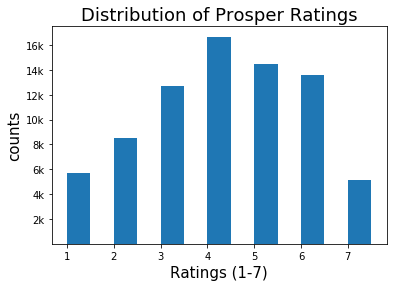

In [13]:
bin_edges = np.arange(1, LoanDataClean['ProsperRating (numeric)'].max()+1, 0.5) 
plt.hist(data = LoanDataClean, x = 'ProsperRating (numeric)', bins = bin_edges);
tick_locs = [1, 2, 3, 4, 5, 6, 7]
plt.xticks(tick_locs, tick_locs);

plt.title('Distribution of Prosper Ratings', fontsize = 18);
plt.xlabel('Ratings (1-7)', fontsize = 15);
plt.ylabel('counts', fontsize = 15);

plt.yticks([2000,4000,6000,8000,10000,12000,14000,16000], ['2k','4k','6k','8k','10k','12k','14k','16k']);

## Frequencies of Loan Statuses
> The highest frequency is for the *"Current"* status, then *"Completed"* and *"Chargedoff"*. The other values have a much smaller frequency, which required to "zoom" in the chart to see the related columns.
>
> This is an ordinal variable, therefore the values are ordered from worst (*"Defaulted"*) to best ("*Completed*"). 
> To investigate how good is the risk evaluation system of the company, we would need to exclude the values "Current", as the outcome is still unknown, and only evaluate the remaining data against the Prosper Rating, expecting more completed loans from higher scored borrowers and more defaulted, chargedoff and past due from lower scored borrowers.

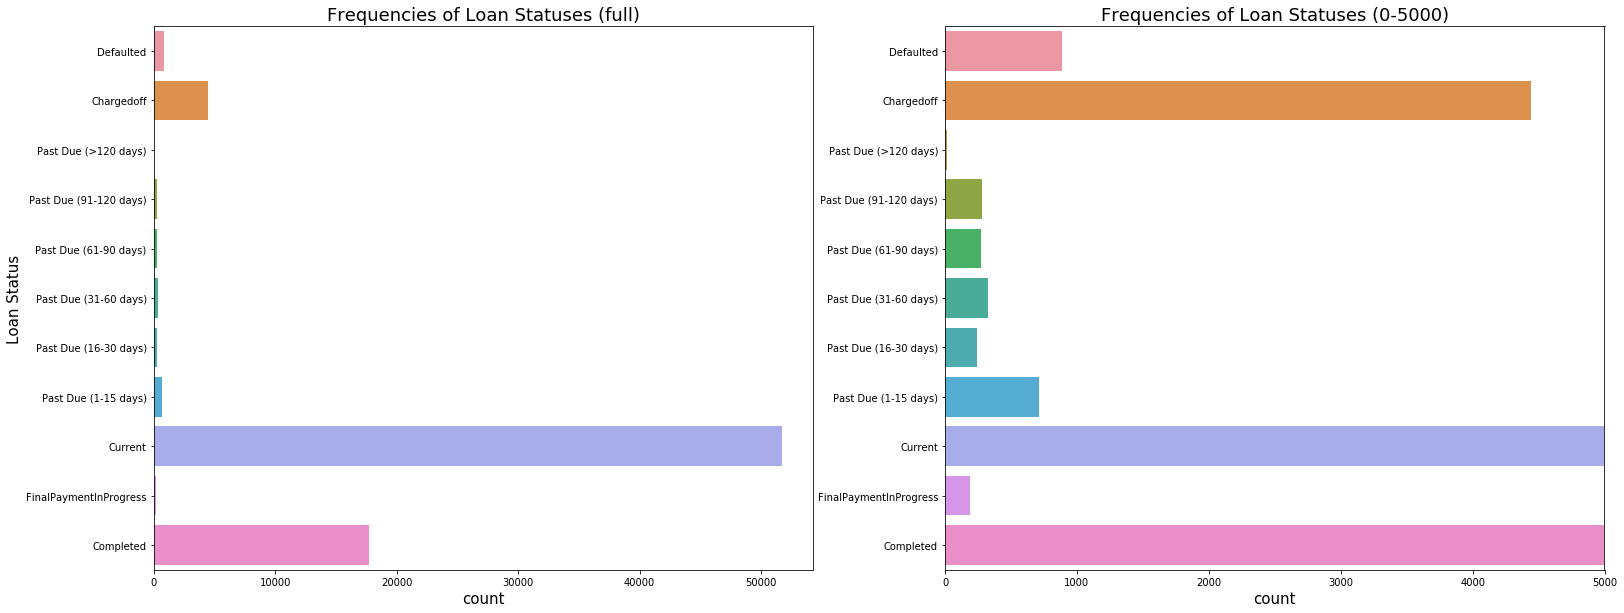

In [14]:
plt.figure(figsize = [26, 10])

# histogram on left: full data
plt.subplot(1, 2, 1)
sns.countplot(data = LoanDataClean, y = 'LoanStatus');
plt.title('Frequencies of Loan Statuses (full)', fontsize = 18);
plt.xlabel('count', fontsize = 15);
plt.ylabel('Loan Status', fontsize = 15);

# histogram on right: zoom on values with lower frequency
plt.subplot(1, 2, 2)
sns.countplot(data = LoanDataClean, y = 'LoanStatus');
plt.xlim(0,5000);
plt.title('Frequencies of Loan Statuses (0-5000)', fontsize = 18);
plt.xlabel('count', fontsize = 15);
plt.ylabel(' ', fontsize = 15);

## Frequencies of Employment Statuses
> The most frequent value is by far *"Employed"*, followed by *"Full-time"* and *"Other"*. The other values are very far from these frequencies.
>
> Also I assumed an ordinal nature for this qualitative variable, therefore it is in order of decreasing risk, where *"Not Employed"* is associated with the highest risk (as if a borrower has no steady sources of income is less likely that can pay the debt back) and *"Employed"* is assocuated with the lowest risk (as the borrower would have a steady source of income).

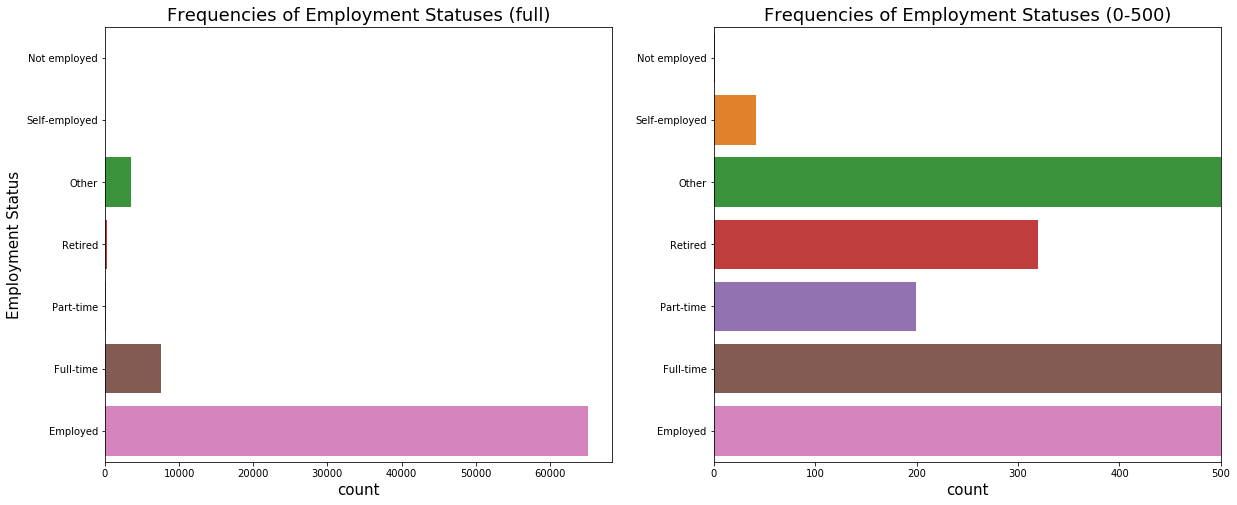

In [15]:
plt.figure(figsize = [20, 8])

# histogram on left: full data
plt.subplot(1, 2, 1)
sns.countplot(data = LoanDataClean, y = 'EmploymentStatus');

plt.title('Frequencies of Employment Statuses (full)', fontsize = 18);
plt.xlabel('count', fontsize = 15);
plt.ylabel('Employment Status', fontsize = 15);

# histogram on right: zoom on values with lower frequency
plt.subplot(1, 2, 2)
sns.countplot(data = LoanDataClean, y = 'EmploymentStatus');
plt.xlim(0,500);

plt.title('Frequencies of Employment Statuses (0-500)', fontsize = 18);
plt.xlabel('count', fontsize = 15);
plt.ylabel(' ', fontsize = 15);

## Relation between the three main features of interest: Prosper Rating, Borrower Rate and Loan Status

> From a point-plot, we can observe a strong inverse correlation between the Rating and the Borrower Rate. 

> There is also a weaker correlation between the Borrower Rate and the Loan Status, with Borrower Rate being higher for statuses with more negative outcome.
Clear exceptions that make this pattern weaker are the *"Defaulted"* status has borrower rate slightly lower then *"Chargedoff" *status, as well as the *"FinalPaymentInProgress"* status has borrower rate lower then *"Completed"*.

> We can also see a pattern of increasing Prosper Rating as we move to statuses with more positive outcome. This is especially evident from the *"ProsperRating vs LoanStatus"* bar-chart, where the *"Completed"* and *"FinalPaymentInProgress"* statuses show the highest average rating with low variation, while the lowest rating are shown by the "Defaulted" and *"Chargedoff"* statuses. An intermediate rating is shown by the *"Past Due"* statuses, representing the uncertainty of their outcome.

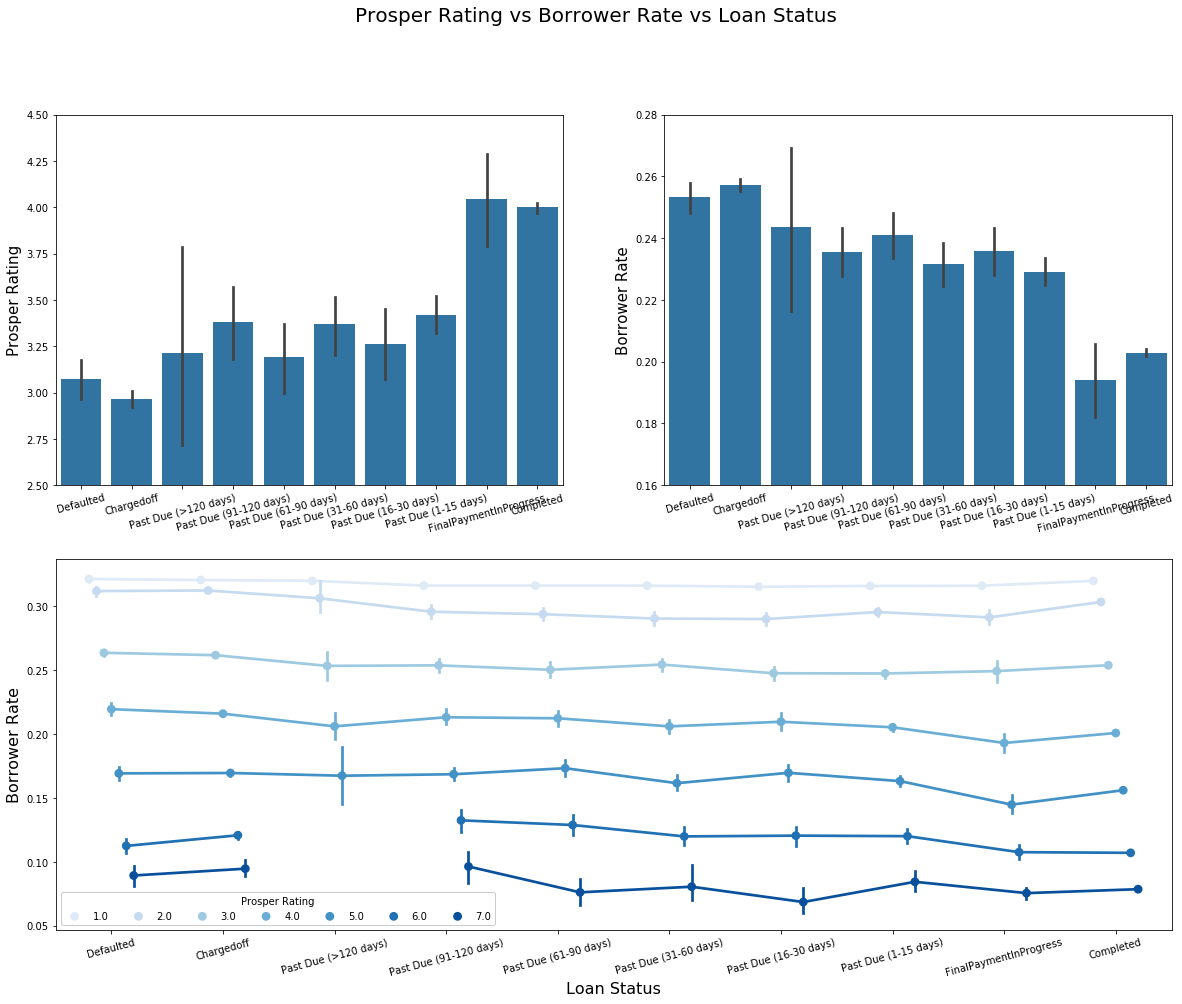

In [16]:
fig = plt.figure(figsize = [20, 15])
fig.suptitle('Prosper Rating vs Borrower Rate vs Loan Status', fontsize = 20)

base_color = sns.color_palette()[0]

plt.subplot(2, 1, 2)
ax = sns.pointplot(data = LoanDataOutcome, x = 'LoanStatus', y = 'BorrowerRate', hue = 'ProsperRating (numeric)', dodge = 0.4, linestyles = "-", palette = 'Blues');
ax.legend(loc = 3, ncol = 11, framealpha = 1, title = 'Prosper Rating');
plt.xticks(rotation = 15);
plt.xlabel('Loan Status', fontsize = 16);
plt.ylabel('Borrower Rate', fontsize = 16);


# ProsperRating (numeric) vs LoanStatus
plt.subplot(2, 2, 1)
ax = sns.barplot(data = LoanDataOutcome, x = 'LoanStatus', y = 'ProsperRating (numeric)', color =base_color)
plt.xticks(rotation = 15); 
plt.ylim(2.5,4.5);
plt.xlabel(' ', fontsize = 16);
plt.ylabel('Prosper Rating', fontsize = 15);

# Borrower Rate relates to the Loan Status
plt.subplot(2, 2, 2)
ax = sns.barplot(data = LoanDataOutcome, x = 'LoanStatus', y = 'BorrowerRate', color =base_color)
plt.xticks(rotation = 15);
plt.ylim(0.16,0.28);
plt.ylabel('Borrower Rate', fontsize = 15);
plt.xlabel(' ', fontsize = 16);

## Prosper Rating by Debt/Income Ratio and Employment Status

> Excluding the *"Not employed"* and *"Self-employed"* statuses, as not significative, the heat-map shows the overall pattern where the rating increases moving from top to bottom, which means as the debt/income ratio decreases. However this pattern becomes weaker for the top values of the debt/income ratio displayed (over 0.8).
It's worth mentioning that this patter is extremely consistent in the *"Employed"* status, and as the *"Employed"* status is the most frequent, it plays a big role in defining the overall pattern.
>
> Also as we move to the right along the **x** axis (which means from more unstable to more stable employment statuses), we can see an overall increase in the rating. 
In particular, the zone with the highest rating is for *"Retired"*, *"Part-time"*, *"Full-time"* and *"Employed"* up to a maximum of 0.2 debt/income ratio. 
Interesting to notice that the highest ratings are for Part-timers with a debt/income ratio over 0.9, and this is due to 3 outliers that are the only data-points in those 2 cells.

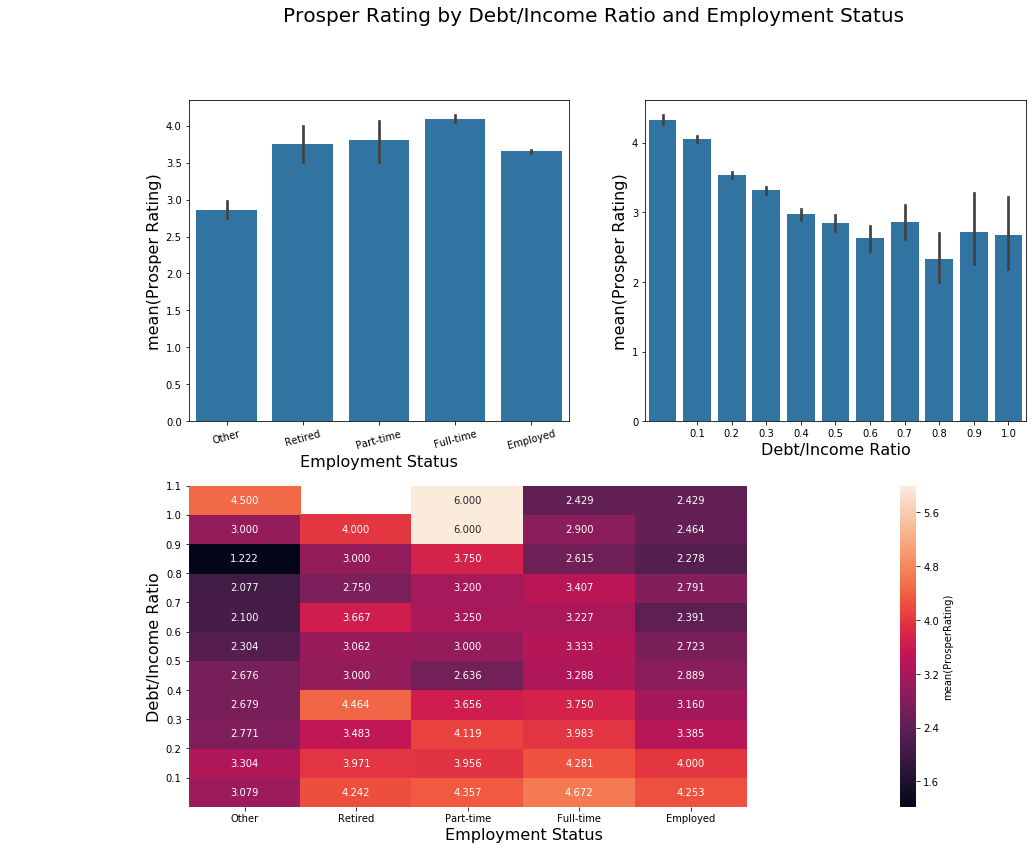

In [17]:
fig = plt.figure(figsize = [15, 13])

fig.suptitle('Prosper Rating by Debt/Income Ratio and Employment Status', fontsize = 20)

base_color = sns.color_palette()[0]

# chart on top left
plt.subplot(2, 2, 1)
ax = sns.barplot(data = LoanDataOutcome2, x = 'EmploymentStatus', y = 'ProsperRating (numeric)', color =base_color)
plt.xlim(1.5,6.5);
plt.xticks(rotation = 15);
plt.xlabel('Employment Status', fontsize = 16);
plt.ylabel('mean(Prosper Rating)', fontsize = 16);

# chart on top right
plt.subplot(2, 2, 2)
#ax = sns.barplot(data = LoanDataOutcomeWONo_Self, x = 'ProsperRating (numeric)', y = 'DebtToIncomeRatio', color =base_color)
ax = sns.barplot(data = LoanDataOutcome2, x = 'DebtToIncomeRatioDisc', y = 'ProsperRating (numeric)', color =base_color)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1]);
plt.ylabel('mean(Prosper Rating)', fontsize = 16);
plt.xlabel('Debt/Income Ratio', fontsize = 16);
plt.xlim(-0.5,10.5);

# chart on bottom
plt.subplot(2, 1, 2)
cat_means = LoanDataOutcome2.groupby(['EmploymentStatus','DebtToIncomeRatioDisc']).mean()['ProsperRating (numeric)'] 
cat_means = cat_means.reset_index(name = 'ProsperRating (numeric)_avg')
cat_means = cat_means.pivot(index = 'DebtToIncomeRatioDisc', columns = 'EmploymentStatus', values = 'ProsperRating (numeric)_avg')
sns.heatmap(cat_means, annot = True, fmt = '.3f', cbar_kws = {'label' : 'mean(ProsperRating)'});
plt.xlim(2,8);
plt.ylim(0,11);
plt.yticks([1,2,3,4,5,6,7,8,9,10,11], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1]);
plt.ylabel('Debt/Income Ratio', fontsize = 16);
plt.xlabel('Employment Status', fontsize = 16);

## Borrower Rate by Debt/Income Ratio and Employment Status

> We can see a very similar pattern to the one presented in the previous visualization, but with opposite signs between the Borrower Rate and the previous Prosper Rating, and this makes sense as they are inversely correlated, as seen before. 

> The Borrower Rate decreases moving from top to bottom, as the debt/income ratio decreases. Weaker pattern for the debt/income ratio values over 0.8.
Also amoving from more unstable to more stable employment statuses, we can observe an overall decrease in the Borrower Rate. In particular, the zone with the lowest rates is for Retired, Part-timers, Full-timers and Employed up to a maximum of 0.2 debt/income ratio.

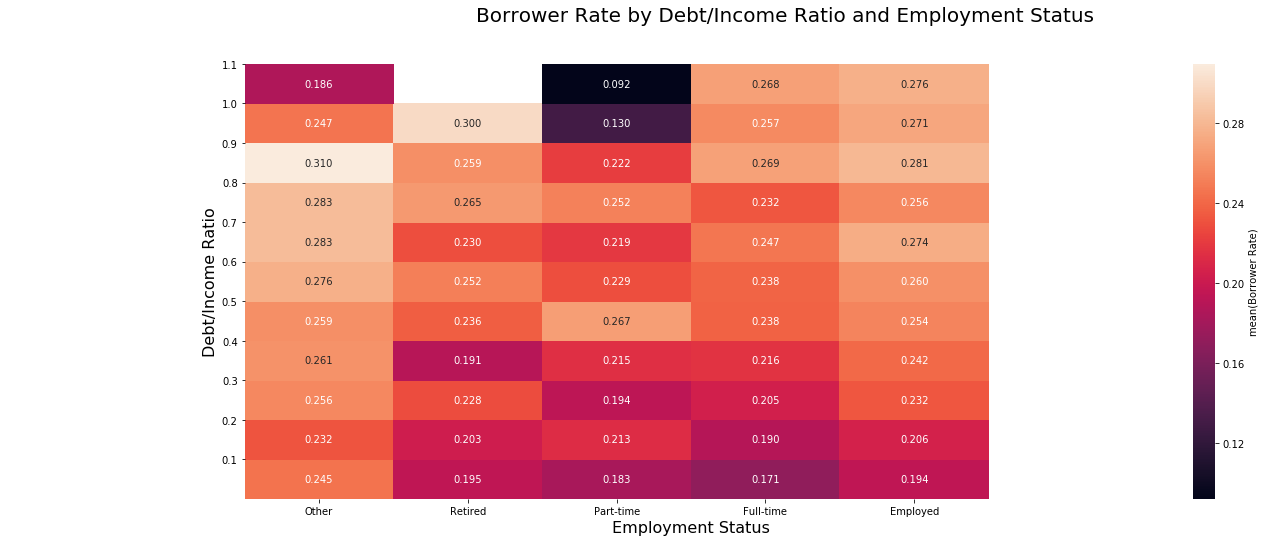

In [18]:
fig = plt.figure(figsize = [20, 8])

fig.suptitle('Borrower Rate by Debt/Income Ratio and Employment Status', fontsize = 20)

cat_means = LoanDataOutcome2.groupby(['EmploymentStatus','DebtToIncomeRatioDisc']).mean()['BorrowerRate'] 
cat_means = cat_means.reset_index(name = 'BorrowerRate_avg')
cat_means = cat_means.pivot(index = 'DebtToIncomeRatioDisc', columns = 'EmploymentStatus', values = 'BorrowerRate_avg')
sns.heatmap(cat_means, annot = True, fmt = '.3f', cbar_kws = {'label' : 'mean(Borrower Rate)'});
plt.xlim(2,8);
plt.ylim(0,11);
plt.yticks([1,2,3,4,5,6,7,8,9,10,11], [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1]);
plt.xlabel('Employment Status', fontsize = 16);
plt.ylabel('Debt/Income Ratio', fontsize = 16);

## Prosper Rating by Amount Delinquent and Delinquencies in the Last 7 Years

> In a 3-Dimensional scatter plot, we can clearly see the pattern where the Amount Delinquent and the Delinquencies in the Last 7 Years are negatively correlated to the Prosper Rating. Indeed, the lower we go along the vertical axis, the more the data-points increase their spread (variability). In particular, moving down, more and more data-points deviate towards higher values of Amount Delinquent (to the right along the x-axis) and Delinquencies in the last 7 years (to the rear along the y-axis).

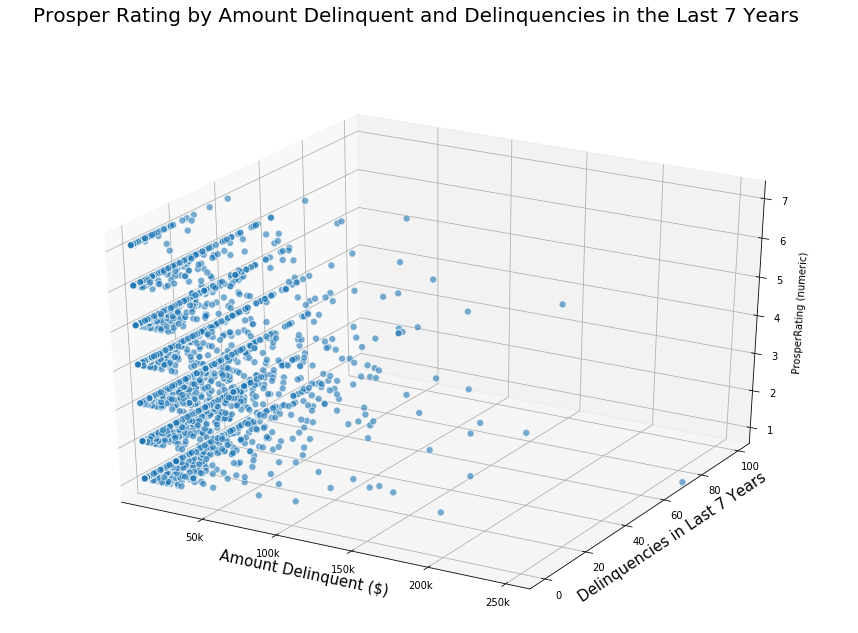

In [19]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d');

fig.suptitle('Prosper Rating by Amount Delinquent and Delinquencies in the Last 7 Years', fontsize = 20)

xs = LoanDataOutcome['AmountDelinquent']
ys = LoanDataOutcome['DelinquenciesLast7Years']
zs = LoanDataOutcome['ProsperRating (numeric)']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w'); 

ax.set_xlabel('AmountDelinquent');
ax.set_ylabel('DelinquenciesLast7Years');
ax.set_zlabel('ProsperRating (numeric)');

plt.xlim(0,260000);

plt.xlabel('Amount Delinquent ($)', fontsize = 15);
plt.ylabel('Delinquencies in Last 7 Years', fontsize = 15);

plt.xticks([50000,100000,150000,200000,250000], ['50k','100k','150k','200k','250k']);

## Stated Monthly Income by Employment Status and Loan Status

> The heat-map shows the breakdown of the two bar-charts on top:
>
> `a` We can confirm the overall pattern that as we move to the right, from lower stability employments to higher stability ones, the average income increases, except for the part-timers which have the lowest value (which makes sense as the income is also proportional to the number of hours worked).
>
> `b` We can see that the pattern shown on the bar-chart on the top right (average income increasing with the positivity of the outcome of the loan) is not consistent through the different employment statuses, and it seems mainly due to the "Employed" status being the one with the majority of the data-points, therefore biasing the overall means.

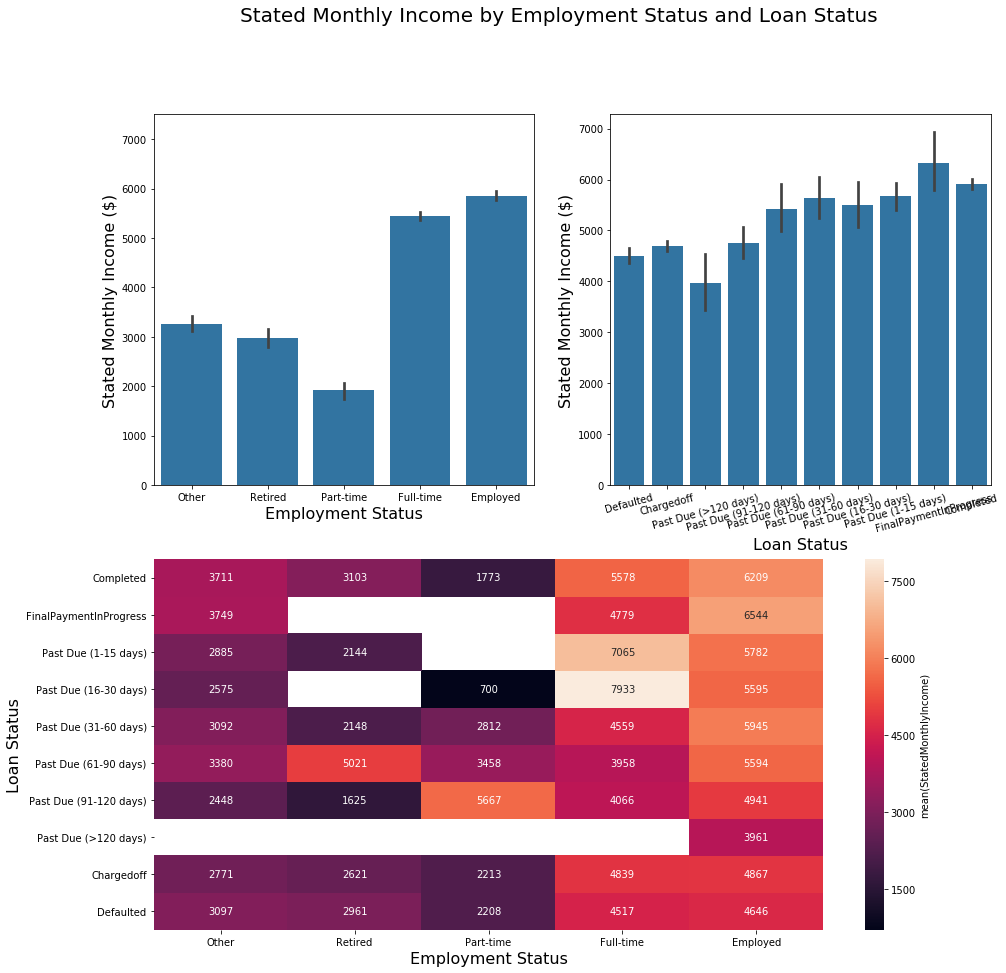

In [20]:
fig = plt.figure(figsize = [15, 15])

fig.suptitle('Stated Monthly Income by Employment Status and Loan Status', fontsize = 20)

# chart on top left
plt.subplot(2, 2, 1)
base_color = sns.color_palette()[0]
ax = sns.barplot(data = LoanDataOutcomeWONo_Self, x = 'EmploymentStatus', y = 'StatedMonthlyIncome', color =base_color)
plt.ylim(0,7500);
plt.ylabel('Stated Monthly Income ($)', fontsize = 16);
plt.xlabel('Employment Status', fontsize = 16);

# chart on top right
plt.subplot(2, 2, 2)
base_color = sns.color_palette()[0]
ax = sns.barplot(data = LoanDataOutcomeWONo_Self, x = 'LoanStatus', y = 'StatedMonthlyIncome', color =base_color)
plt.xticks(rotation = 15); 
plt.ylabel('Stated Monthly Income ($)', fontsize = 16);
plt.xlabel('Loan Status', fontsize = 16);

# chart on bottom
plt.subplot(2, 1, 2)
cat_means = LoanDataOutcomeWONo_Self.groupby(['EmploymentStatus', 'LoanStatus']).mean()['StatedMonthlyIncome']
cat_means = cat_means.reset_index(name = 'StatedMonthlyIncome_avg')
cat_means = cat_means.pivot(index = 'LoanStatus', columns = 'EmploymentStatus', values = 'StatedMonthlyIncome_avg')
ax = sns.heatmap(cat_means, annot = True, fmt = '.0f', cbar_kws = {'label' : 'mean(StatedMonthlyIncome)'});
ax.invert_yaxis()

plt.xlabel('Employment Status', fontsize = 16);
plt.ylabel('Loan Status', fontsize = 16);